/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/100], Loss: 0.1132, Training RMSE: 0.3319, Validation RMSE: 0.3180, Training R²: -0.03, Validation R²: -0.03
Epoch [2/100], Loss: 0.1115, Training RMSE: 0.3313, Validation RMSE: 0.3183, Training R²: -0.02, Validation R²: -0.03
Epoch [3/100], Loss: 0.1102, Training RMSE: 0.3192, Validation RMSE: 0.3081, Training R²: 0.04, Validation R²: 0.04
Epoch [4/100], Loss: 0.1013, Training RMSE: 0.3025, Validation RMSE: 0.2878, Training R²: 0.14, Validation R²: 0.16
Epoch [5/100], Loss: 0.0922, Training RMSE: 0.2794, Validation RMSE: 0.2685, Training R²: 0.26, Validation R²: 0.27
Epoch [6/100], Loss: 0.0840, Training RMSE: 0.2791, Validation RMSE: 0.2704, Training R²: 0.27, Validation R²: 0.26
Epoch [7/100], Loss: 0.0810, Training RMSE: 0.2728, Validation RMSE: 0.2662, Training R²: 0.30, Validation R²: 0.28
Epoch [8/100], Loss: 0.0758, Training RMSE: 0.2577, Validation RMSE: 0.2569, Training R²: 0.37, Validation R²: 0.33
Epoch [9/100], Loss: 0.0733, Training RMSE: 0.2556, Validation RMSE:

ValueError: x and y must have same first dimension, but have shapes (100,) and (51,)

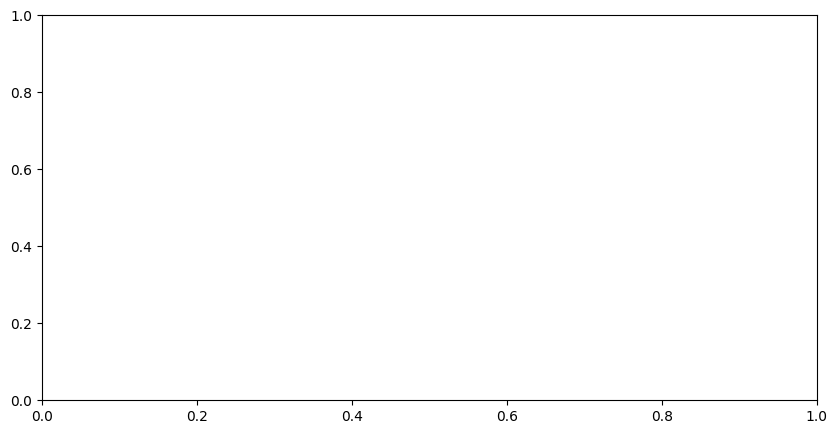

In [ ]:
                                      #Done by: Omar Mohamed Elsayed
                                      #round code:
                                      #model accuracy: 0.78
                                      #i know the accuracy is a bit low with some percentage of overfitting
                                      #but it's my first project with cnn and dnn,I hope you will like it :)
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

#The structure of CNN Model contains of 7 convolution processes with 3 filters each, Maxpooling was applied after every convolution process.
# then reducing the number of neurons to result in 3 output neurons in the last layer.

#At the end of the forward propagation process, the tensor is flattend for fully connected layers that each neuron in current layer will be
# connected to all previous neurons(getting all their outputs).

#Dropout was used to reduce the overfitting, there's still some segnificant overfitting percentage, but increasing dropout more than that
# will lead to worse results(by experiencing in this model)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(128 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 3)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))

        x = x.view(-1, 128 * 3 * 3)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x



class HeadPoseDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)        #read the csv file then transforming the dataset to (450*450) pixels if it's not.
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)                    #getting the length of the dataset.

    def __getitem__(self, idx):
        img_path = self.data_frame.iloc[idx, 1]
        yaw = self.data_frame.iloc[idx, 2] / 180       #Normalizing the yaw, pitch and roll in the dataset to reduce training time.
        pitch = self.data_frame.iloc[idx, 3] / 180
        roll = self.data_frame.iloc[idx, 4] / 180

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        labels = torch.tensor([yaw, pitch, roll], dtype=torch.float32)
        return img, labels


transform = transforms.Compose([                      #Image transformations and dataset loading.
    transforms.Resize((450, 450)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   #normalizing pixels between 0 and 1.
])







csv_file_path = '/content/drive/MyDrive/data.csv'
dataset = HeadPoseDataset(csv_file=csv_file_path, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=10, timeout=60)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=10, timeout=60)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")        #selecting the gpu if available.

                                                                             # Initialize model, loss, and optimizer
model = CNNModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)                         #adjusting the learning rate.


def calculate_rmse(loader):
    model.eval()
    total_rmse = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            mse = ((outputs - labels) ** 2).mean().item()
            rmse = mse ** 0.5
            total_rmse += rmse * labels.size(0)
            total_samples += labels.size(0)

    return total_rmse / total_samples

def calculate_r2(loader):
    model.eval()
    total_variance = 0
    explained_variance = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            for i in range(3):  # Assuming yaw, pitch, and roll
                total_variance += ((labels[:, i] - labels[:, i].mean()) ** 2).sum().item()
                explained_variance += ((labels[:, i] - outputs[:, i]) ** 2).sum().item()

            total_samples += labels.size(0)

    return 1 - (explained_variance / total_variance)

# Early stopping variables
patience = 6
best_val_rmse = float('inf')
epochs_no_improve = 0
early_stop = False


# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate training and validation RMSE and R²
    train_rmse = calculate_rmse(train_loader)
    val_rmse = calculate_rmse(val_loader)

    train_r2 = calculate_r2(train_loader)
    val_r2 = calculate_r2(val_loader)


    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, '
          f'Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}, '
          f'Training R²: {train_r2:.2f}, Validation R²: {val_r2:.2f}')

    # Early stopping process
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        epochs_no_improve = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/model_weights.pth')  # Save best model weights
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        early_stop = True
        break

if not early_stop:
    print("Training finished without early stopping.")


<ipython-input-23-3619e227ce9b>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('/content/drive/MyDrive/model_weights.pth', map_locati

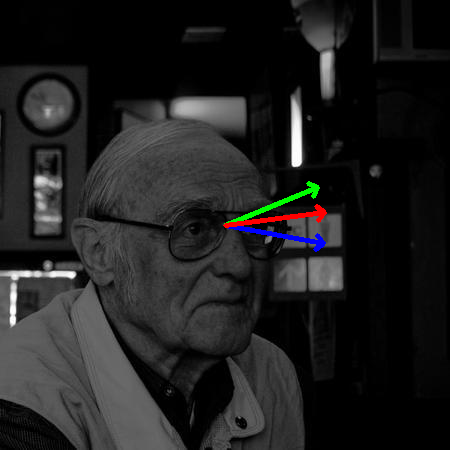

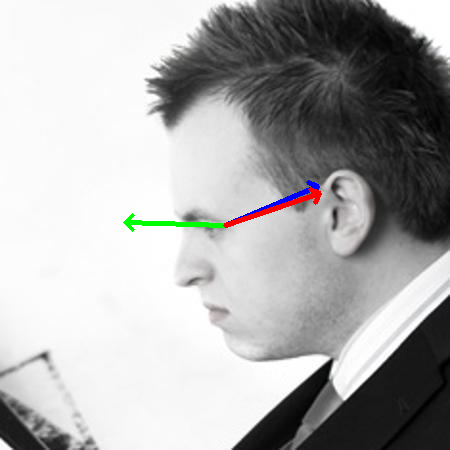

In [23]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(128 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 3)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))

        x = x.view(-1, 128 * 3 * 3)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

transform = transforms.Compose([
    transforms.Resize((450, 450)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_model = CNNModel().to(device)     #making new instance model with same structure
new_model.load_state_dict(torch.load('/content/drive/MyDrive/model_weights.pth', map_location=torch.device('cpu')))  #loading the weights
new_model.eval()                      #setting the model to evaluation mode.

def drawypr(img_path): #draw yaw, pitch and roll on image.

    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    output = new_model(img)
    output = output*180
    yaw ,pitch,roll = float(output[0][0]),float(output[0][1]),float(output[0][2])
    img = cv2.imread(img_path)
    center = (img.shape[0]//2,img.shape[1]//2)
    length = 100
    line_thickness = 3


    yaw_end = (int(center[0] + length * np.cos(np.radians(yaw))),
               int(center[1] - length * np.sin(np.radians(yaw))))
    pitch_end = (int(center[0] + length * np.sin(np.radians(pitch))),
                 int(center[1] - length * np.cos(np.radians(pitch))))
    roll_end = (int(center[0] + length * np.cos(np.radians(roll))),
                int(center[1] - length * np.sin(np.radians(roll))))
    cv2.arrowedLine(img, center, yaw_end, (255,0,0), line_thickness)
    cv2.arrowedLine(img, center, pitch_end, (0,255,0), line_thickness)
    cv2.arrowedLine(img, center, roll_end, (0,0,255), line_thickness)
    cv2_imshow(img)










img_path = '/content/drive/MyDrive/AFLW2000/image02748.jpg'
drawypr(img_path)
drawypr('/content/drive/MyDrive/AFLW2000/image00010.jpg')
